### The correlates of crackling

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import seaborn as sns
import xarray as xr
from frites.conn.conn_tf import _tf_decomp
from frites.stats import confidence_interval
from frites.utils import parallel_func
from mne.filter import filter_data
from mne.stats import fdr_correction
from tqdm import tqdm

from config import get_dates, return_delay_split, return_evt_dt
from GDa.loader import loader
from GDa.session import session
from GDa.stats.bursting import find_start_end

In [3]:
def hilbert_spectra(
    data, fsample, freqs, bandwidth, n_jobs=1, verbose=False, kw_filter={}
):
    """
    Compute the Hilbert spectra of a 3D data array.

    Parameters:
    - data (xr.DataArray): Input data array with dimensions ("trials", "roi", "time").
    - fsample (float): Sampling frequency of the data.
    - freqs (array-like): Center frequencies for the spectral analysis.
    - bandwidth (float): Half-width of the frequency bands.
    - n_jobs (int, optional): Number of parallel jobs to run for filtering. Default is 1.
    - verbose (bool, optional): If True, print verbose messages during filtering. Default is False.
    - kw_filter (dict, optional): Additional keyword arguments for the `filter_data` function.

    Returns:
    - xr.DataArray: Hilbert spectra of the input data, with dimensions ("trials", "roi", "freqs", "times").

    Note:
    The input data is filtered into frequency bands centered at the specified frequencies with the given bandwidth.
    The Hilbert transform is then applied to obtain the analytic signal, and the squared magnitude of the analytic
    signal is computed to obtain the Hilbert spectra.

    The resulting DataArray has dimensions representing trials, regions of interest (ROIs), frequency bins, and time points.
    """

    from mne.filter import filter_data

    assert isinstance(data, xr.DataArray)

    dims = data.dims
    coords = data.coords
    attrs = data.attrs

    np.testing.assert_array_equal(dims, ("trials", "roi", "time"))

    lfreqs = np.clip(freqs - bandwidth, 0, np.inf)
    hfreqs = freqs + bandwidth

    bands = np.stack((lfreqs, hfreqs), axis=1)

    data_filtered = []
    for lf, hf in bands:
        data_filtered += [
            filter_data(
                data.values,
                fsample,
                lf,
                hf,
                n_jobs=n_jobs,
                **kw_filter,
                verbose=verbose
            )
        ]
    data_filtered = np.stack(data_filtered, axis=1)
    hilbert = scipy.signal.hilbert(data_filtered, axis=-1)
    sxx = hilbert * np.conj(hilbert)

    sxx = xr.DataArray(
        sxx.real,
        dims=("trials", "freqs", "roi", "times"),
        coords=(coords["trials"], freqs, coords["roi"], coords["time"]),
    ).transpose("trials", "roi", "freqs", "times")

    sxx.attrs = attrs

    return sxx

#### Setting configurations

In [4]:
_ROOT = os.path.expanduser("~/funcog/gda/")
metric = "coh"
monkey = "lucy"

In [5]:
sessions = get_dates(monkey)

In [6]:
evt_dt = return_evt_dt("cue", monkey)
stages = [[-0.5, -0.2], [0, 0.4], [0.5, 0.9], [0.9, 1.3], [1.1, 1.5]]
stage_labels = ["P", "S", "D1", "D2", "Dm"]

In [7]:
data_loader = loader(_ROOT=_ROOT)

#### Loading LFP, unities and power

In [125]:
# Window in which the data will be read
evt_dt = return_evt_dt("cue", monkey=monkey)
# Path to LFP data
raw_path = os.path.expanduser("~/funcog/gda/GrayLab/")
# Instantiate class
ses = session(
    raw_path=raw_path,
    monkey=monkey,
    date="141017",
    session=1,
    slvr_msmod=True,
    align_to="cue",
    evt_dt=evt_dt,
)

# Read LFP
ses.read_from_mat()
LFP = ses.filter_trials(trial_type=[1], behavioral_response=[1])

roi_channel = [f"{r} ({c})" for r, c in zip(LFP.roi.data, LFP.attrs["channels_labels"])]
LFP = LFP.assign_coords({"roi": roi_channel})

# Read SPIKES
ses.read_from_mat(load_spike_times=True)
SPIKES = ses.spike_times.sel(trials=LFP.trials)

(595, 94, 3650)


In [126]:
SPIKES = SPIKES.assign_coords({"roi": roi_channel})

In [127]:
kw_loader = dict(
    session="141017",
    aligned_at="cue",
    channel_numbers=True,
    monkey=monkey,
    decim=5,
    mode="hilbert",
)

POWER = data_loader.load_power(**kw_loader, trial_type=1, behavioral_response=1)

ZPOWER = (POWER - POWER.mean("times")) / POWER.std("times")

In [128]:
kw_loader = dict(
    session="141017",
    aligned_at="cue",
    channel_numbers=True,
    monkey=monkey,
    decim=5,
    mode="morlet",
)

POWER2 = data_loader.load_power(**kw_loader, trial_type=1, behavioral_response=1)

ZPOWER2 = (POWER - POWER.mean("times")) / POWER.std("times")

In [211]:
CRACKLES = ZPOWER2 >= 3

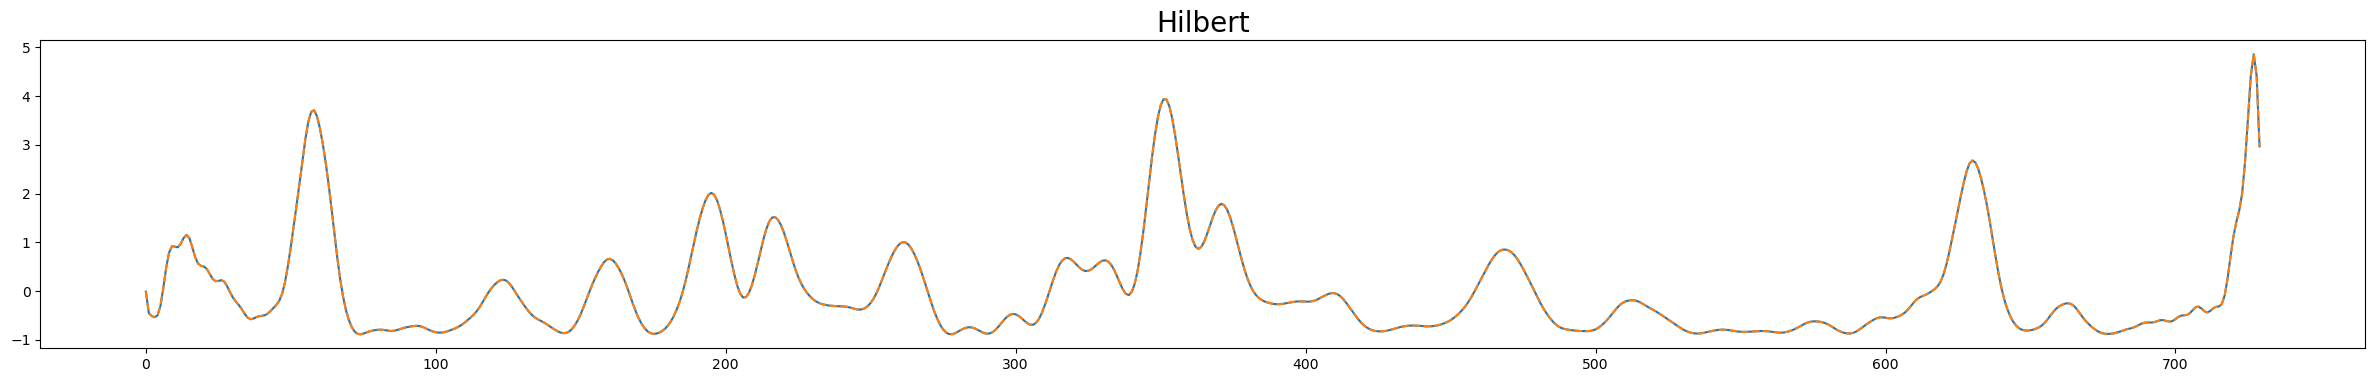

In [130]:
plt.figure(figsize=(30, 4))
plt.plot(ZPOWER.sel(roi="a3 (106)", freqs=27)[10])
plt.plot(ZPOWER2.sel(roi="a3 (106)", freqs=27)[10], "--")
plt.title("Hilbert", fontsize=20)
plt.savefig("test.png")

In [138]:
LFP_FILTERED.roi

<xarray.DataArray 'roi' (roi: 94)>
array(['a46D (1)', 'a8B (4)', 'F6 (8)', 'a9/46D (9)', 'a8M (10)', 'a8B (11)',
       'a8B (12)', 'F7 (13)', 'F7 (14)', 'a8r (15)', 'a8M (16)', 'a8M (17)',
       'a8B (18)', 'F7 (19)', 'F7 (20)', 'a8L (21)', 'a8r (22)', 'a8M (23)',
       'a8M (24)', 'F2 (28)', 'a44 (29)', 'F2 (34)', 'F2 (36)', 'a8L (38)',
       'a8L (39)', 'a8L (40)', 'F2 (43)', 'F2 (44)', 'F2 (45)', 'F2 (54)',
       'F1 (59)', 'F1 (63)', 'a3 (64)', 'a3 (65)', 'F1 (69)', 'F1 (73)',
       'F1 (83)', 'F1 (84)', 'a2 (86)', 'F1 (92)', 'F1 (95)', 'a1 (101)',
       'a1 (103)', 'F1 (104)', 'F1 (105)', 'a3 (106)', 'a7B (110)',
       'AIP (111)', 'a2 (112)', 'a1 (114)', 'a1 (115)', 'a1 (116)', 'a3 (117)',
       'a7B (121)', 'a7B (122)', 'a5 (124)', 'a2 (125)', 'a2 (126)',
       'a1 (127)', 'a5 (136)', 'a2 (138)', 'TPt (141)', 'a5 (149)',
       'a7A (156)', 'a5 (161)', 'V4t (163)', 'DP (168)', 'a5 (172)',
       'MT (175)', 'DP (177)', 'a7A (181)', 'V6A (183)', 'DP (191)',
       'PIP (193)', 'DP (201)', 'V2 (203)', 'V2 (204)', 'V6A (205)',
       'V1 (206)', 'V1 (212)', 'V2 (214)', 'V2 (215)', 'V1 (219)', 'V2 (222)',
       'V2 (224)', 'V1 (232)', 'V1 (233)', 'V1 (241)', 'V1 (242)', 'V1 (245)',
       'V1 (247)', 'V1 (248)', 'V1 (250)', 'V1 (251)'], dtype='<U10')
Coordinates:
  * roi      (roi) <U10 'a46D (1)' 'a8B (4)' 'F6 (8)' ... 'V1 (250)' 'V1 (251)'

In [132]:
LFP_FILTERED = filter_data(LFP.data, 1000, 25, 40)
LFP_FILTERED = xr.DataArray(LFP_FILTERED, dims=LFP.dims, coords=LFP.coords)

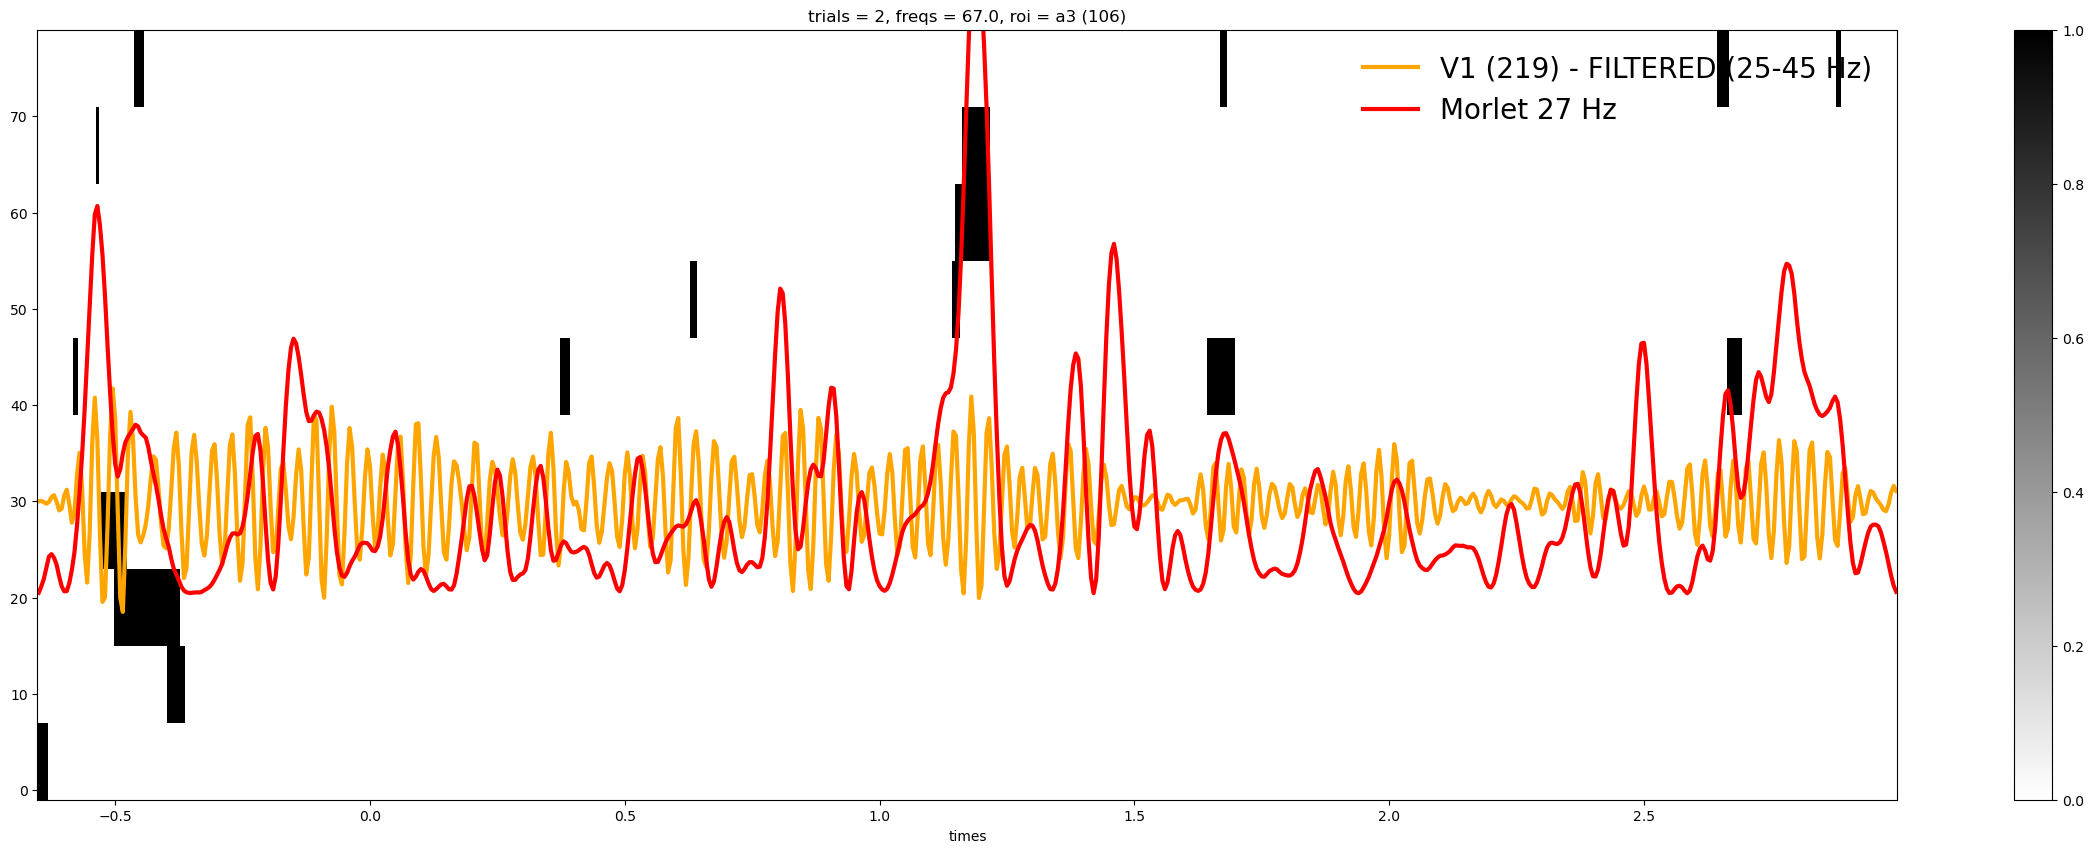

In [189]:
plt.figure(figsize=(30, 10))
CRACKLES.sel(roi="a3 (106)").isel(trials=0).plot(cmap="binary")
((LFP_FILTERED.sel(roi="a3 (106)")[0][..., ::5] * 5e4 + 30)).plot(lw=3, c="orange", label="V1 (219) - FILTERED (25-45 Hz)")
((ZPOWER2.sel(roi="a3 (106)", freqs=67)[0] * 10 + 30)).plot(lw=3, c="r", label="Morlet 27 Hz")
plt.legend(fontsize=20, frameon=False)
plt.savefig("superimposed.pdf")

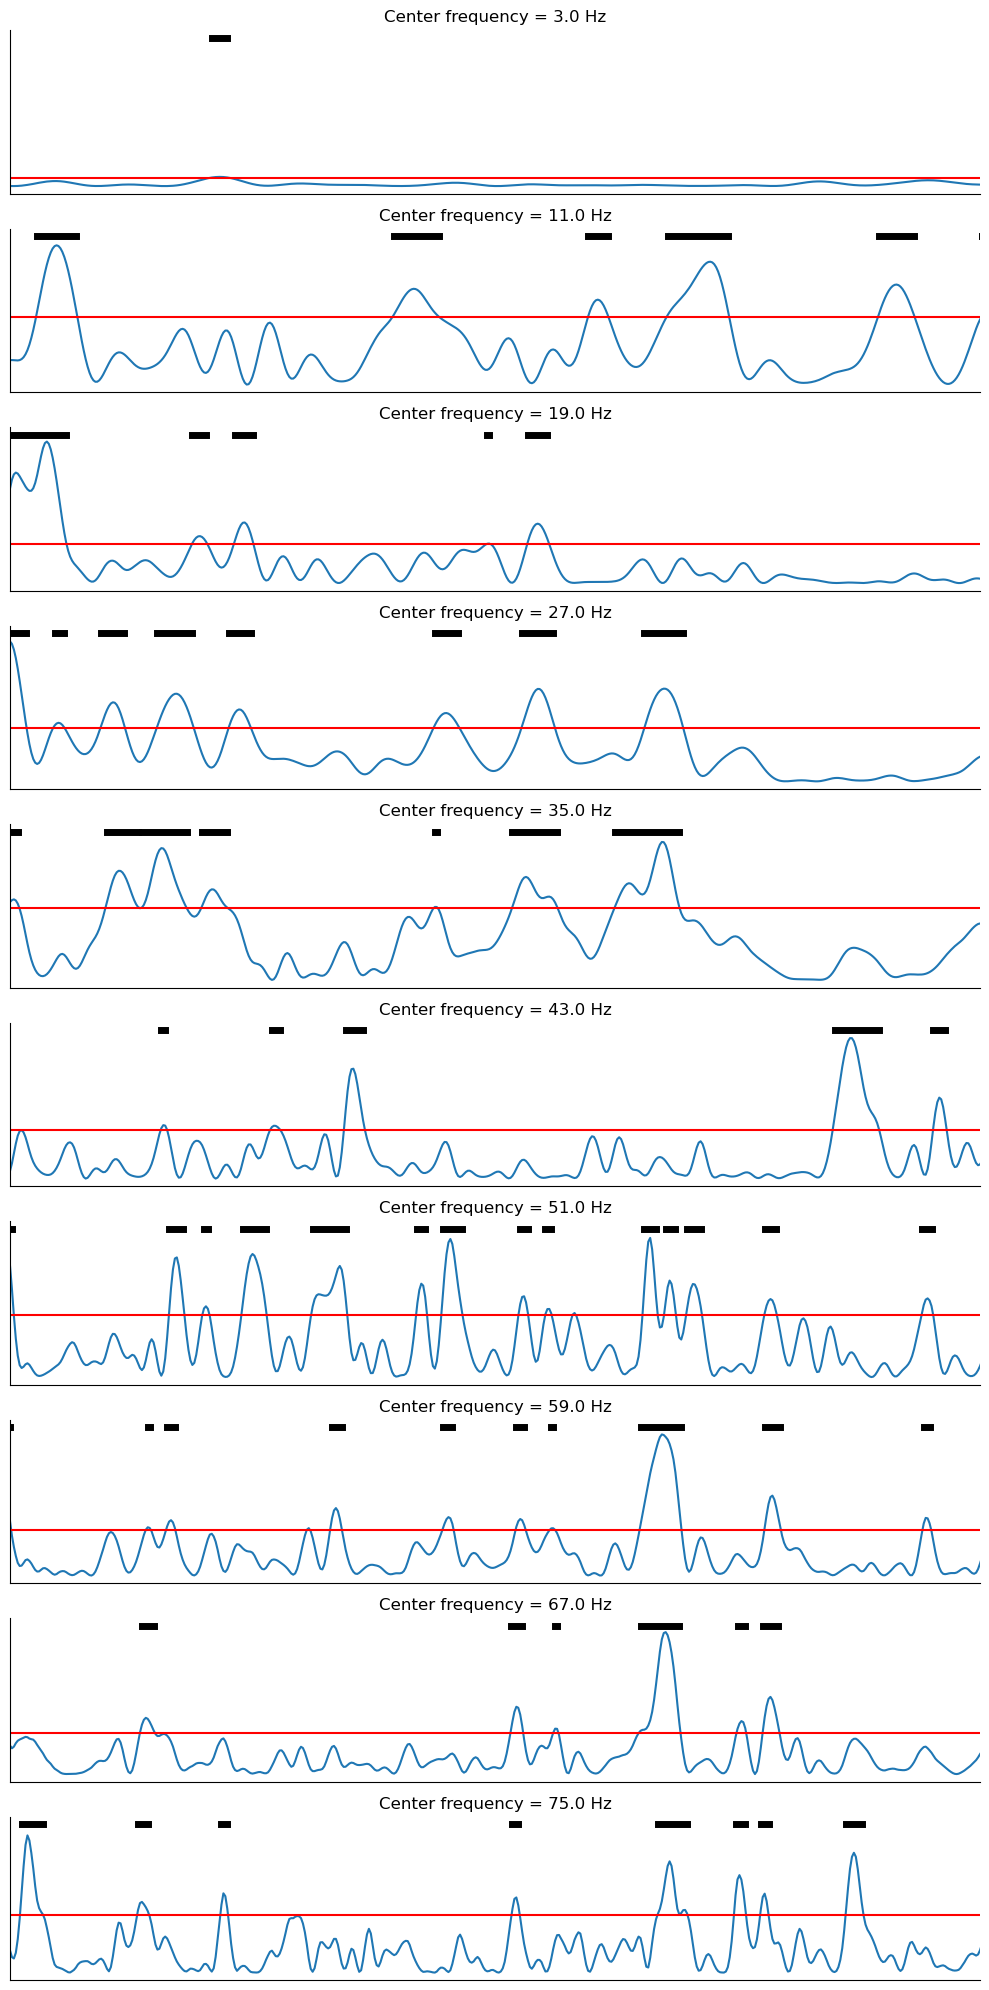

In [261]:
plt.figure(figsize=(10, 20))

CRACKLES = ZPOWER2 >= 1

for pos, freq in enumerate(ZPOWER.freqs.data):
    ax = plt.subplot(10, 1, pos + 1)
    x = CRACKLES.sel(roi="a3 (106)", freqs=freq)[0].astype(float)
    y = ZPOWER2.sel(roi="a3 (106)", freqs=freq)[0]
    x[x == 0] = np.nan
    ( x * y.max() + .3 ).plot(c="k", lw="5")
    y.plot()
    plt.hlines(1, -.6, 3, "r")
    plt.xlim(-0.5, 2)
    plt.xticks([])
    plt.yticks([])
    [ax.spines[key].set_visible(False) for key in ["top", "right"]]
    plt.title(f"Center frequency = {freq} Hz")
    plt.xlabel("")
plt.tight_layout()
plt.savefig("crackles.pdf")

In [269]:
CRACKLES.sel(roi="a3 (106)", freqs=27)

<xarray.DataArray (trials: 332, times: 730)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * trials   (trials) int64 2 4 6 9 10 13 14 15 ... 658 659 661 663 765 768 773
    freqs    float64 27.0
    roi      <U10 'a3 (106)'
  * times    (times) float64 -0.65 -0.645 -0.64 -0.635 ... 2.98 2.985 2.99 2.995

In [316]:
CRACKLES = ZPOWER2 >= 1
x = CRACKLES.sel(freqs=27, trials=4).sum("roi")

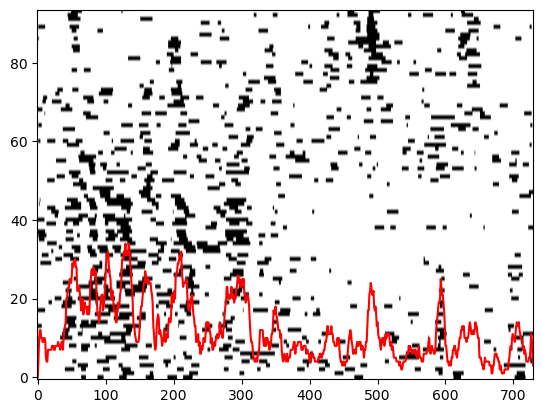

In [318]:
plt.imshow(CRACKLES.sel(freqs=27, trials=4), aspect="auto", cmap="binary", origin="lower")
plt.plot(x, "r")

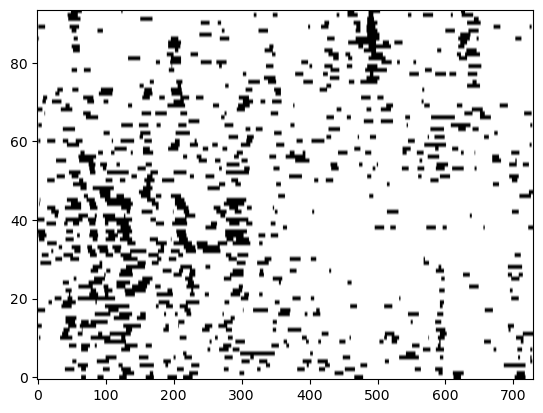

In [373]:
plt.imshow(CRACKLES.sel(freqs=27, trials=4), aspect="auto", cmap="binary", origin="lower")
thr = x > x.quantile(.7)

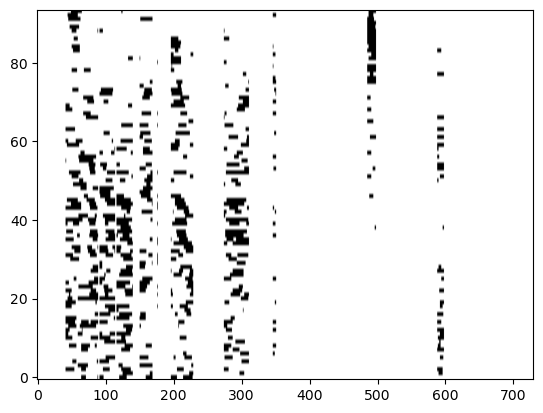

In [381]:
plt.imshow(CRACKLES.sel(freqs=27, trials=4) * thr, aspect="auto", cmap="binary", origin="lower")

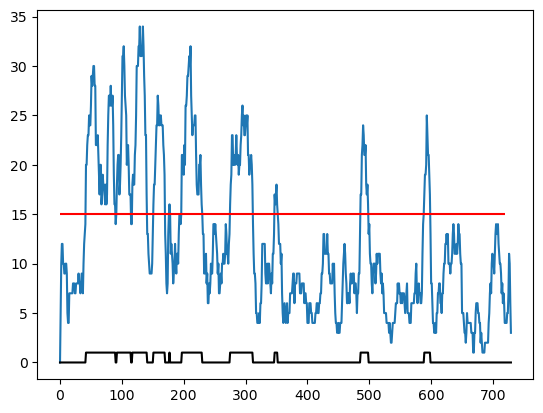

In [372]:
plt.plot(x)
plt.hlines(x.quantile(.7), 0, 720, "r")
plt.plot(x > x.quantile(.7), "k")

In [322]:
find_start_end( (x > x.quantile(.7)).data )

array([[ 42,  90],
       [ 92, 115],
       [117, 141],
       [151, 170],
       [177, 178],
       [197, 230],
       [275, 312],
       [347, 352],
       [486, 499],
       [589, 599]])

In [354]:
A = CRACKLES.sel(freqs=27, trials=4).isel(times=slice(117, 141))

In [355]:
import jax

In [356]:
import jax
import jax.numpy as jnp

# Define your function that computes the outer product of a vector with itself
def outer_product(v):
    return jnp.outer(v, v)

# Vectorize the outer_product function using jax.vmap
vectorized_outer_product = jax.vmap(outer_product, in_axes=1, out_axes=0)

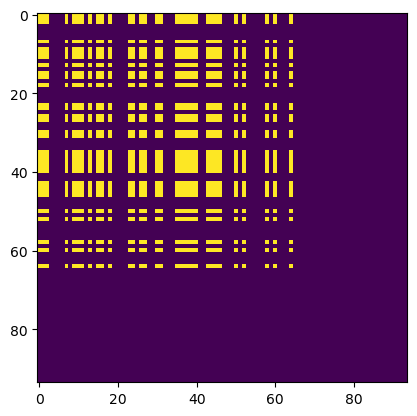

In [366]:
plt.imshow(  np.outer(A[:, 10].data, A[:, 10].data) )

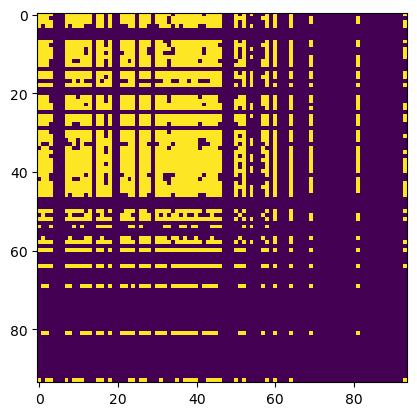

In [367]:
plt.imshow( vectorized_outer_product(A.data).sum(axis=0) > 0 )

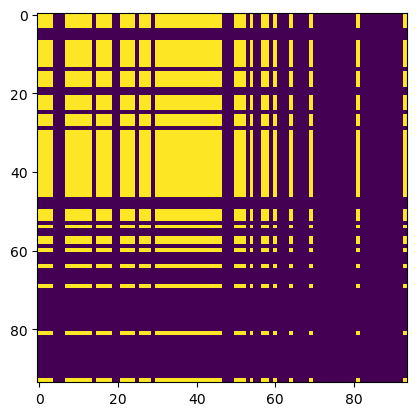

In [369]:
plt.imshow(  np.outer(A.sum(axis=1).data, A.sum(axis=1).data) > 0 )

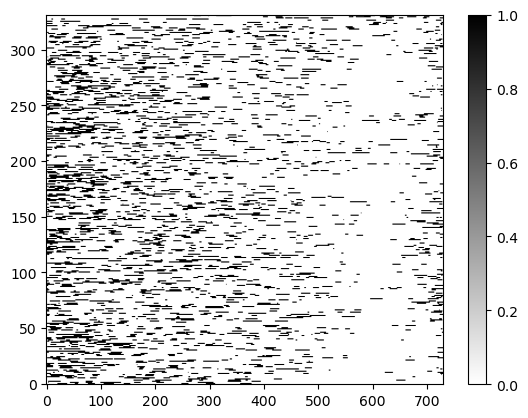

In [284]:
plt.imshow( CRACKLES.sel(roi="a3 (106)", freqs=27), cmap="binary", origin="lower", aspect="auto" )
plt.colorbar()

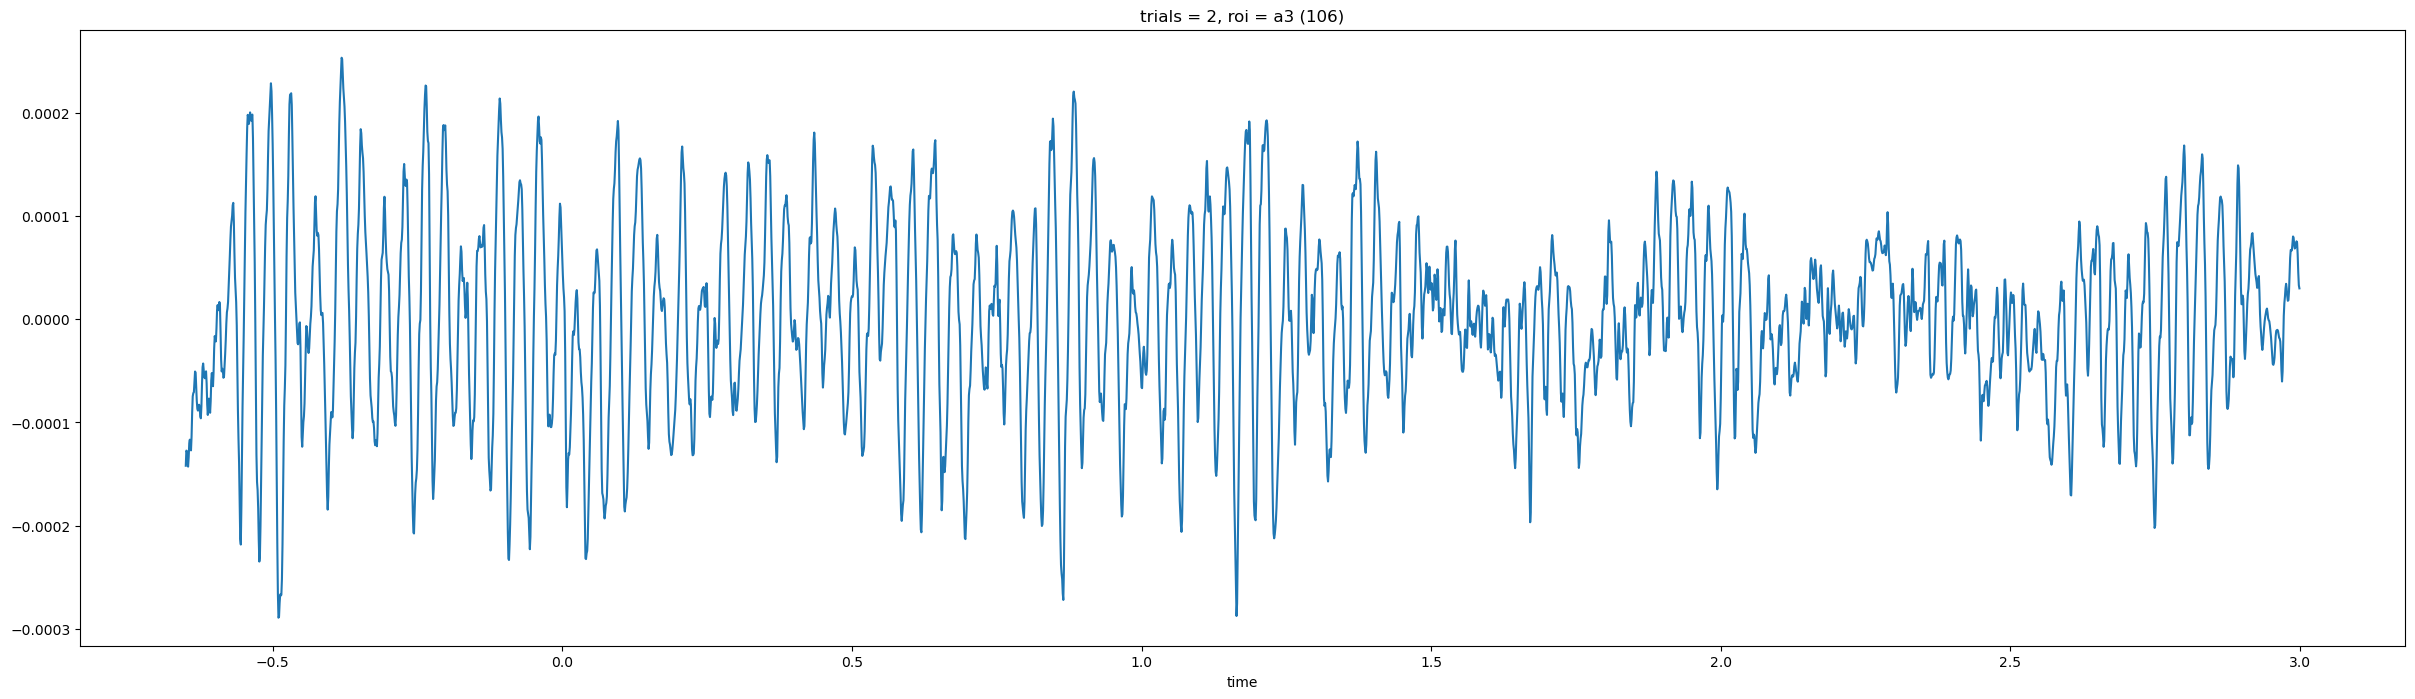

In [153]:
plt.figure(figsize=(30, 8))
LFP.sel(roi="a3 (106)")[0].plot()

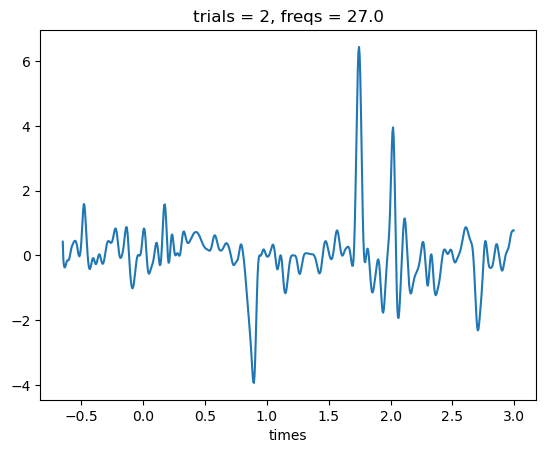

In [188]:
x = ZPOWER.isel(roi=0, trials=0, freqs=3) 
y = ZPOWER.isel(roi=30, trials=0, freqs=3)

(x * y).plot()


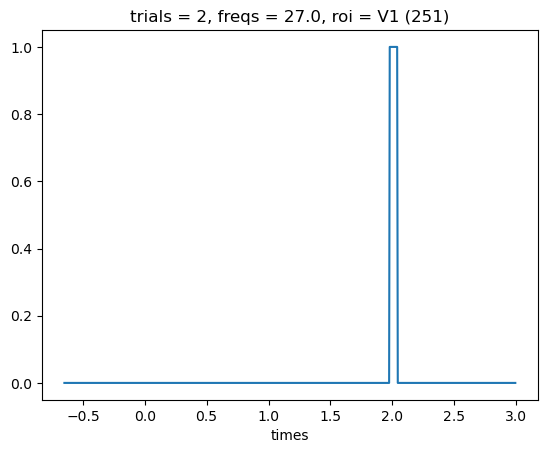

In [181]:
( y >= 3 ).plot()

In [71]:
def triggered_avg(
    data=None,
    spikes=None,
    low_pass=None,
    high_pass=None,
    win_size=None,
    verbose=False,
    decim=None,
):

    n_trials, n_roi, n_times = data.shape
    roi = data.roi.data

    # High-pass filtered data
    data_hp = filter_data(
        data.data, data.fsample, l_freq=low_pass, h_freq=high_pass, verbose=verbose
    )
    # Converts back to DataArray
    data_hp = xr.DataArray(data_hp, dims=data.dims, coords=data.coords)
    """
    data_hp = (data_hp - data_hp.mean(("trials", "time"))) / data_hp.std(
        ("trials", "time")
    )
    """

    if isinstance(decim, int):
        data_hp = data_hp[..., ::decim]
        n_times = data_hp.sizes["time"]

    # win_size = int(win_size * data.fsample)

    data_hp = data_hp.data.swapaxes(0, 1).reshape(n_roi, n_trials * n_times)
    spikes = spikes.data.reshape(n_roi, n_trials * n_times)

    def _for_roi(i):
        peaks = find_start_end(spikes[i]).mean(1).astype(int)
        snipets = np.zeros((len(peaks), 2 * win_size))
        for pidx, idx in enumerate(peaks):
            temp = data_hp[i, (idx - win_size) : (idx + win_size)]
            if len(temp) == 2 * win_size:
                snipets[pidx, :] = temp
        return (
            confidence_interval(snipets, axis=0, verbose=False).squeeze().T
        )  # snipets.mean(0)

    snipets = np.stack([_for_roi(i) for i in range(n_roi)])
    print(snipets.shape)
    times = np.linspace(-win_size, win_size, snipets.shape[1])
    snipets = xr.DataArray(
        snipets,
        dims=("roi", "times", "bounds"),
        coords=(
            roi,
            times,
            ["lower", "higher"],
        ),
    )

    return snipets

In [115]:
def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a, idx, axis=axis)

In [124]:
y = LFP 

CTA = []
nCTA = []

for freq in [27]:

    x = CRACKLES.sel(freqs=freq)

    out = triggered_avg(
        data=SPIKES_CV,
        spikes=x,
        low_pass=1,
        high_pass=250,
        win_size=20,
        decim=5,
        verbose=False,
    )

    x_SHUFFLE = x.copy()
    x_SHUFFLE.values = shuffle_along_axis(x.data, 1)
    
    out1 = triggered_avg(
        data=SPIKES_CV,
        spikes=x_SHUFFLE,
        low_pass=1,
        high_pass=250,
        win_size=20,
        decim=5,
        verbose=False,
    )
    
    CTA += [out]
    nCTA += [out1]

(94, 40, 2)
(94, 40, 2)


In [118]:
CTA = xr.concat(CTA, "freqs").assign_coords({"freqs": [27]})
nCTA = xr.concat(nCTA, "freqs").assign_coords({"freqs": [27]})

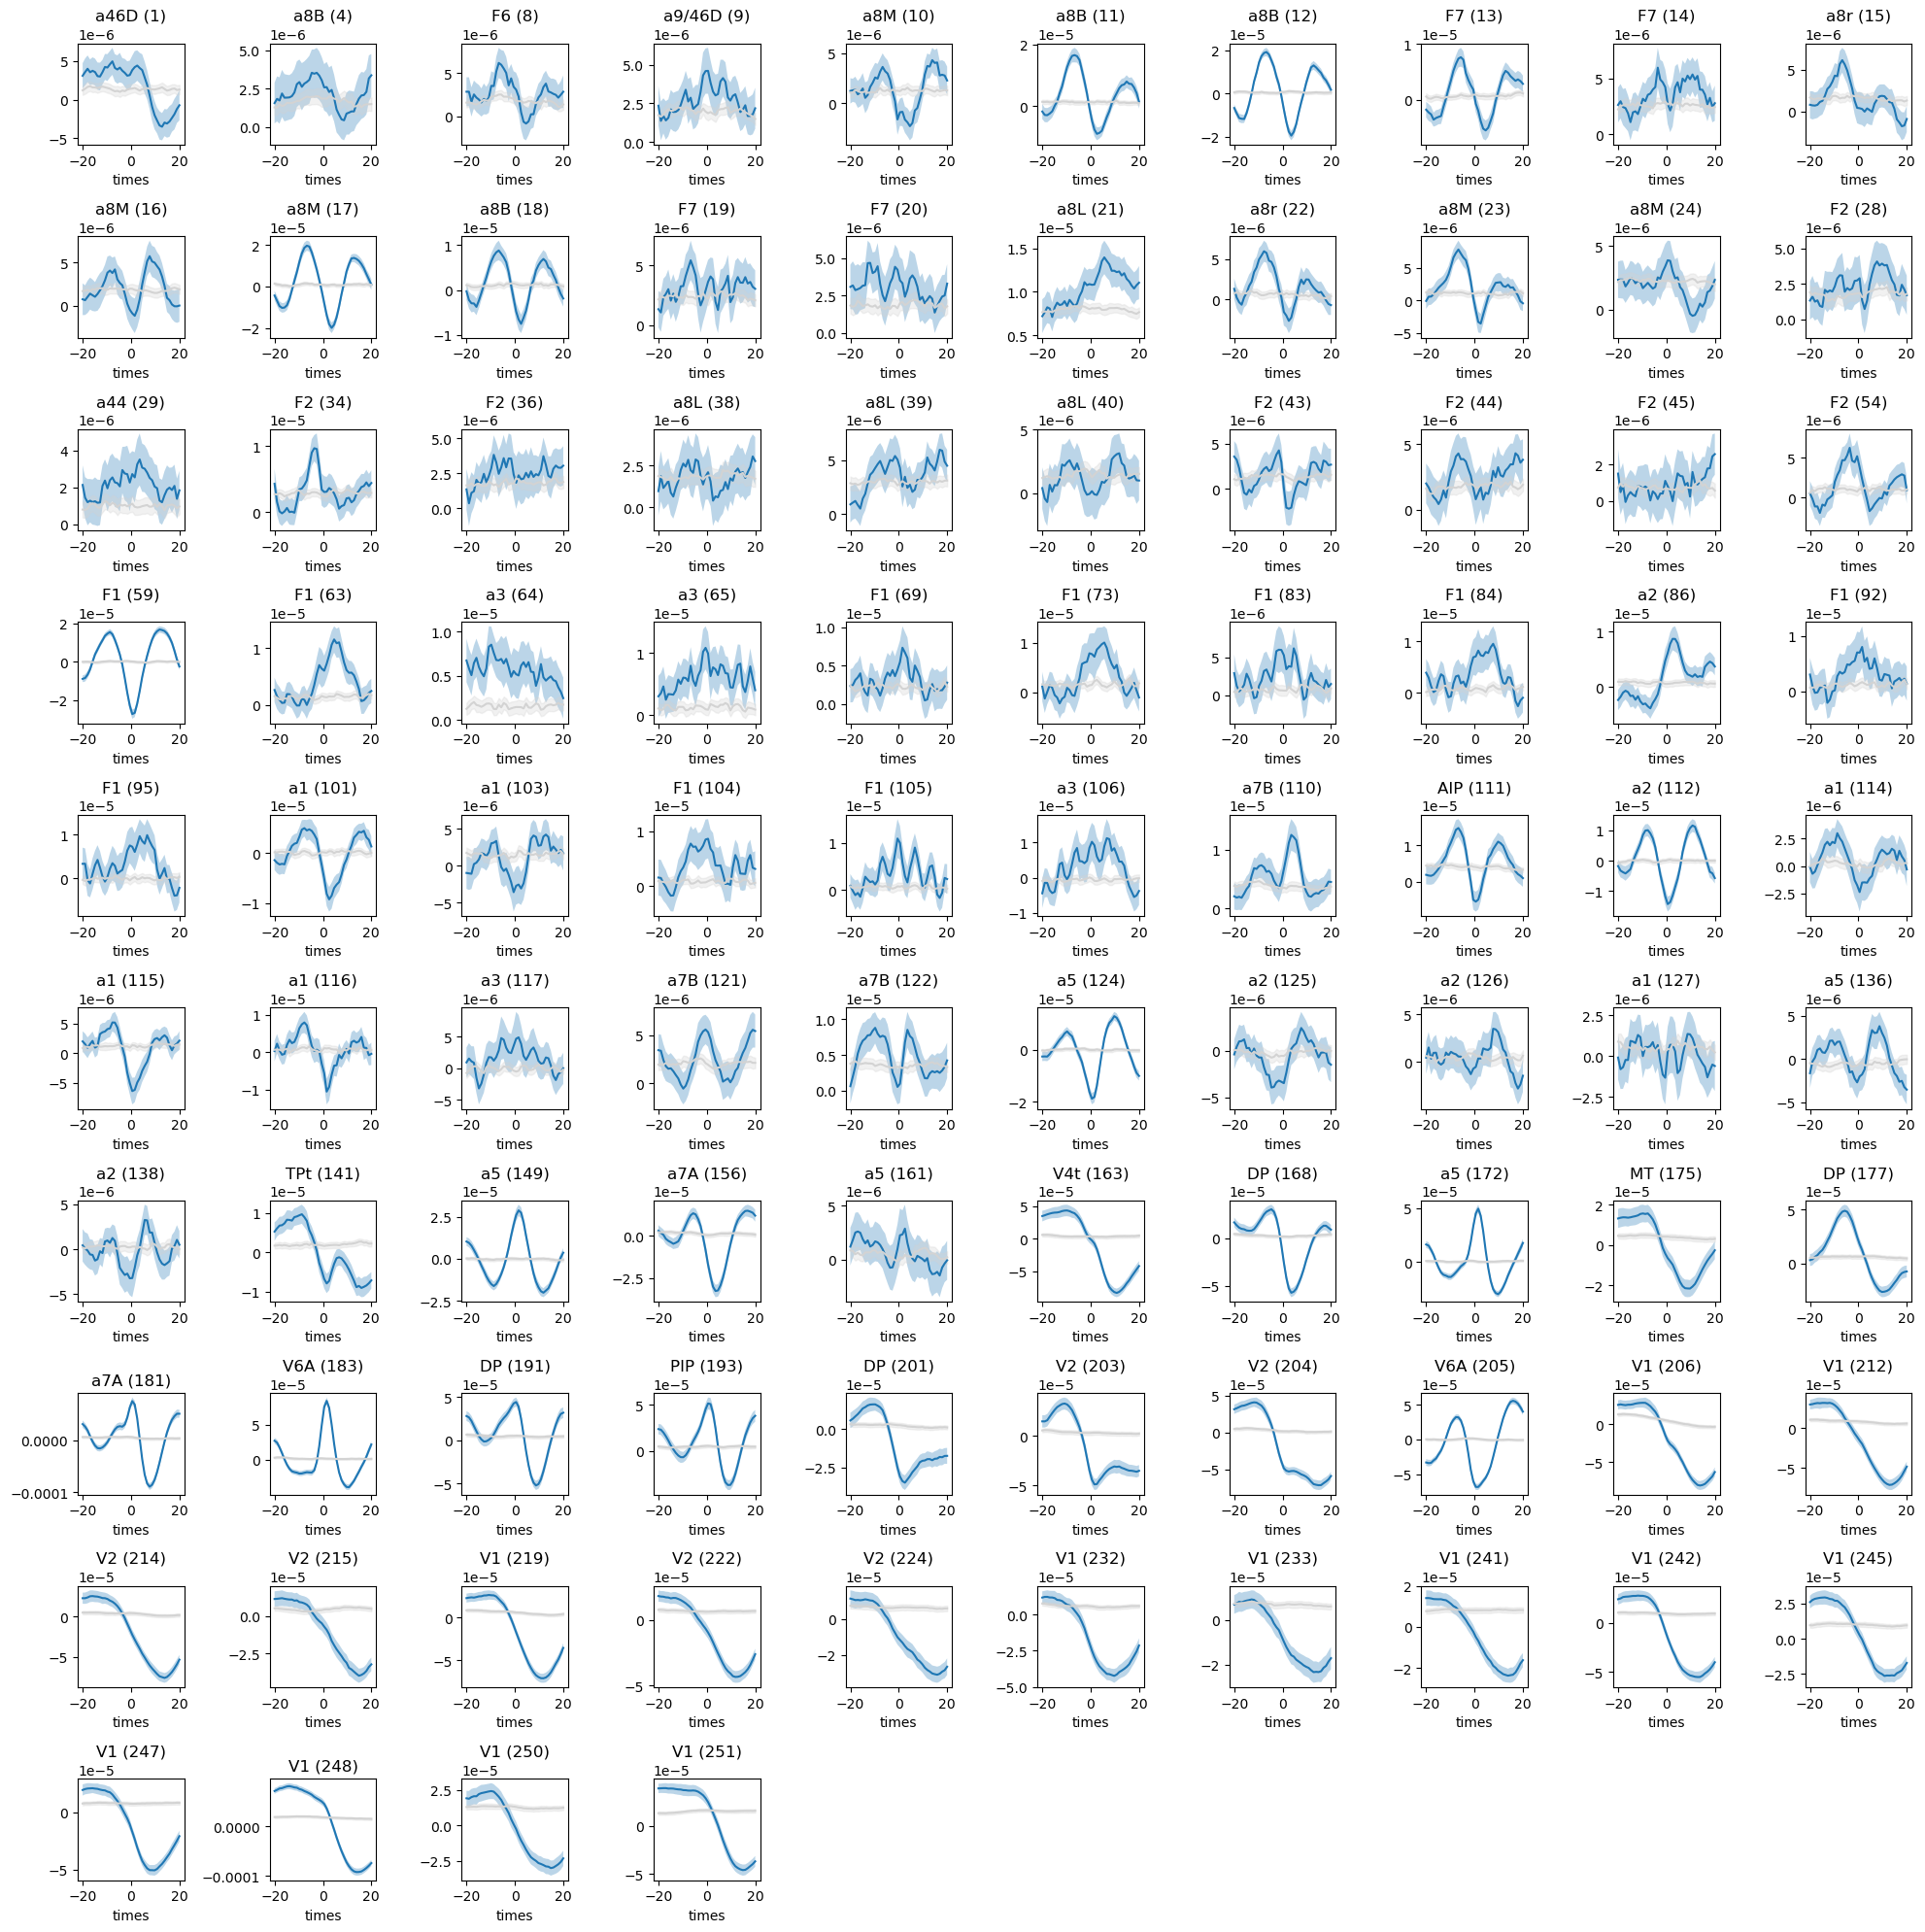

In [122]:
plt.figure(figsize=(20, 20))
unique_rois = np.unique(out.roi.data)
for pos, r in enumerate(out.roi[:100].data):
    plt.subplot(10, 10, pos + 1)
    # Original
    CTA.sel(roi=r, freqs=27).median("bounds").plot()
    plt.fill_between(
        CTA.times,
        CTA.sel(roi=r, freqs=27, bounds="lower"),
        CTA.sel(roi=r, freqs=27, bounds="higher"),
        alpha=0.3,
    )
    # Surrogate
    nCTA.sel(roi=r, freqs=27).median("bounds").plot(c="lightgray")
    plt.fill_between(
        nCTA.times,
        nCTA.sel(roi=r, freqs=27, bounds="lower"),
        nCTA.sel(roi=r, freqs=27, bounds="higher"),
        alpha=0.3,
        color="lightgray"
    )
    plt.title(r)
plt.tight_layout()
plt.savefig("crackle_triggered_average.png")

In [80]:
kernel = np.hanning(100)

In [81]:
SPIKES_CV = scipy.signal.fftconvolve(SPIKES, kernel[None, None, :], axes=2, mode="same")

In [82]:
SPIKES_CV = xr.DataArray(SPIKES_CV, dims=SPIKES.dims, coords=SPIKES.coords)

In [86]:
SPIKES_CV.attrs["fsample"] = 1000

In [459]:
freq = 27

In [460]:
def z_score(data, dim="times"):
    return (data - data.mean(dim)) / data.std(dim)

thr = 1

kw_loader = dict(
    session="141024", aligned_at="cue", channel_numbers=False,
    monkey=monkey, decim=5
)

power = data_loader.load_power(
    **kw_loader, trial_type=1, behavioral_response=1
).sel(freqs=freq, times=slice(-0.5, 2))

times_array = power.times.data
trials_array = power.trials.data
rois = power.roi.data
attrs = power.attrs

# dt
dt = np.diff(times_array)[0]


# z-score power
power = z_score(power)
power.attrs = attrs

# Binarize power
raster = power >= thr
# Summed activity
rho = raster.sum("roi")

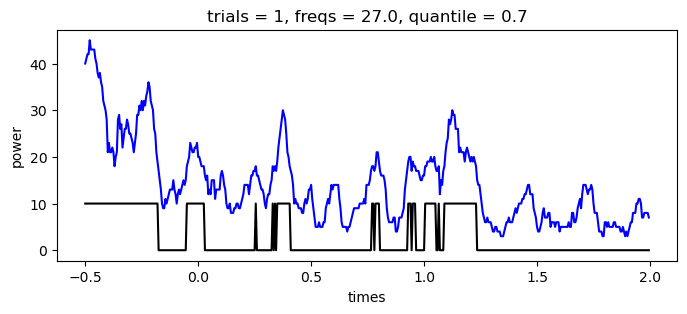

In [461]:
plt.figure(figsize=(8, 3))
(rho ).isel(trials=0).plot(c="b")
((rho > rho.quantile(.7, "times")) * 10).isel(trials=0).plot(c="k")

In [488]:
def find_start_end(array, find_zeros=False):
    """
    Given a binary array find the indexes where the sequences of ones start
    and begin if find_zeros is False. Otherwise it will find the indexes where
    the sequences of zeros start and begin. For instance, for the array
    [0,1,1,1,0,0], would return 1 and 3 respectively for find_zeros=False,
    and 1 and 2 for find_zeros=True.

    Parameters
    ----------
    array: array_like
        Binary array.
    find_zeros: bool | False
        Wheter to find a sequence of zeros or ones

    Returns
    -------
    The matrix containing the start anb ending index
    for each sequence of consecutive ones or zeros with shapes [n_seqs,2]
    where n_seqs is the number of sequences found.
    """
    if find_zeros:
        _bounds = np.array([1])
    else:
        _bounds = np.array([0])

    bounded = np.hstack((_bounds, array, _bounds))
    difs = np.diff(bounded)
    # get 1 at run starts and -1 at run ends if find_zeros is False
    if not find_zeros:
        run_starts, = np.where(difs > 0)
        run_ends, = np.where(difs < 0)
    # get -1 at run starts and 1 at run ends if find_zeros is True
    else:
        run_starts, = np.where(difs < 0)
        run_ends, = np.where(difs > 0)
    return np.vstack((run_starts, run_ends)).T

vectorized_find_start_end = jax.vmap(find_start_end, in_axes=0, out_axes=1)

In [489]:
mask = (rho > rho.quantile(.7, "times"))

In [524]:
stim = power.attrs["stim"]

In [540]:
cc_graphlet = []
trials_array = []
stim_array = []
for trial in tqdm(range(raster.sizes["trials"])):
    x = find_start_end(mask.isel(trials=trial).data)
    y = raster.isel(trials=trial)
    for ti, tf in x:
        temp = vectorized_outer_product(y.isel(times=slice(ti, tf)).data).mean(axis=0)
        cc_graphlet += [
            xr.DataArray(temp, dims=("sources", "targets"), coords=(rois, rois))
        ]
        trials_array += [trial]
        stim_array = [stim[trial]]
    
cc_graphlet = xr.concat(cc_graphlet, "trials").assign_coords({"trials": trials_array})
cc_graphlet.attrs["stim"] = stim_array

100%|███████████████████████████████████████████████████████| 582/582 [00:17<00:00, 34.15it/s]


In [553]:
a = cc_graphlet.sel(trials=20).mean("trials")

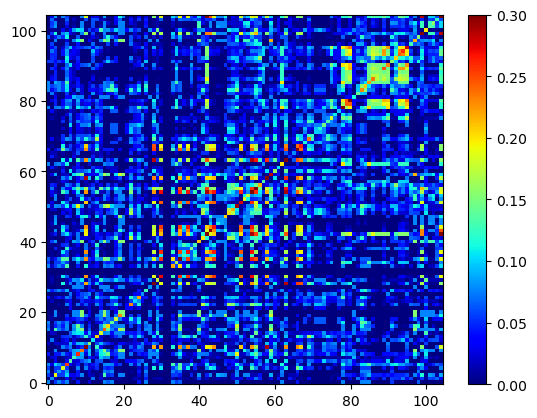

In [554]:
plt.imshow(a, aspect="auto", cmap="jet", origin="lower", vmax=.3)
plt.colorbar()

In [502]:
vectorized_outer_product( y.isel(times=slice(x[0, 0], x[0, 1])).data ).sum(axis=0)

Array([[11, 11,  0, ...,  0,  0,  0],
       [11, 17,  0, ...,  0,  0,  0],
       [ 0,  0, 28, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int32)

In [483]:
np.outer(A[:, 10].data, A[:, 10].data)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

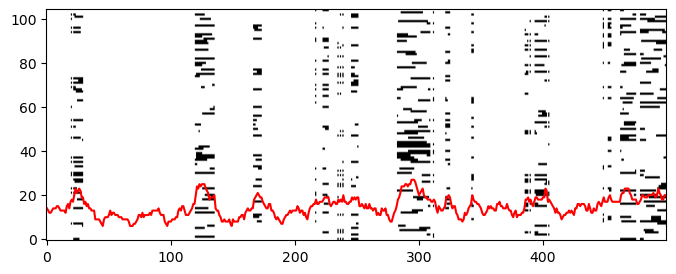

In [452]:
plt.figure(figsize=(8, 3))

plt.imshow(
    (raster * (rho > rho.quantile(0.7, "times"))).isel(trials=0),
    cmap="binary",
    aspect="auto",
    origin="lower",
)
plt.plot(rho.isel(trials=0), "r")

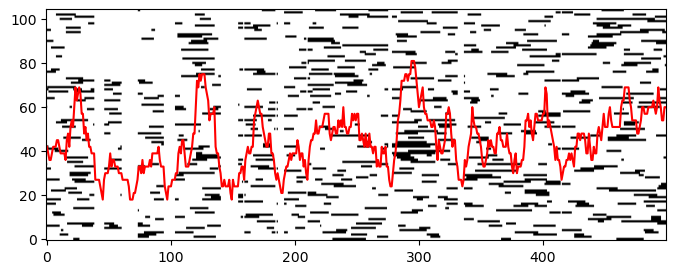

In [435]:
plt.figure(figsize=(8, 3))

plt.imshow(
    raster.isel(trials=0) * (rho.sel(times=slice(-0.5, 2)).isel(trials=0) > 9),
    cmap="binary",
    origin="lower",
    aspect="auto",
)
plt.plot(rho.isel(trials=0) * 3, "r")